# Download historical bitcoin price

In [2]:
# Diff:cryptocmd module is broken which was the third party we demo in vedio. Now,we use yfinance to replace it.
# !pip install yfinance > logt.txt
import yfinance as yf

btc = yf.Ticker("BTC-USD")
ohlcv = btc.history(period="max")
ohlcv.columns = ohlcv.columns.str.lower()

<Axes: xlabel='Date'>

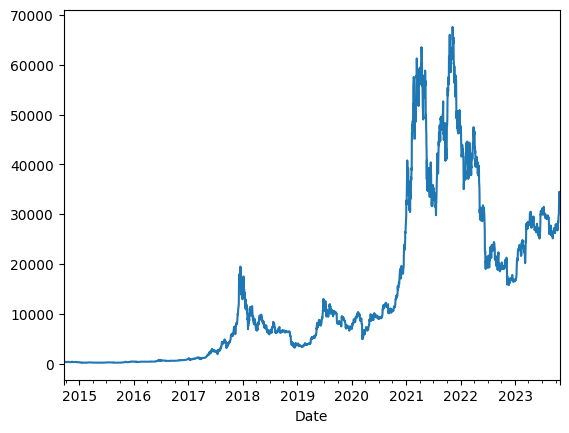

In [3]:
ohlcv.close.plot()

# The Puell Multiple

[reindex api reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.reindex.html)

[resample api reference](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html?highlight=resample#pandas.DataFrame.resample)

<Axes: xlabel='Date'>

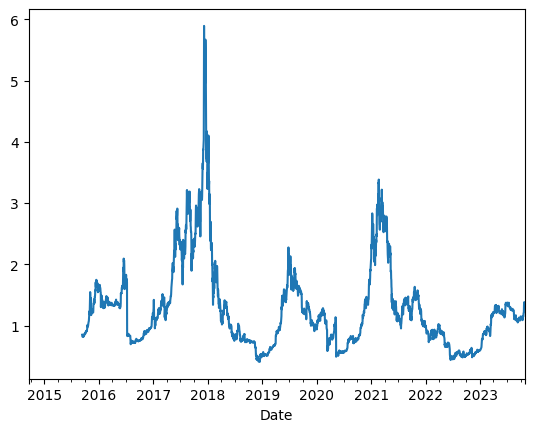

In [4]:
import pandas as pd

"""
Halving 1	28 November 2012	5,250,000
Halving 2	9 July 2016	2,625,000
Halving 3	Expected May 2020	1,312,500
Halving 4	Expected 2024	656,250
"""

dates = {'2012-11-28': 25, '2016-7-9': 12.5, '2020-5-11':6.25, '2024-5-11':3.125}
reward = pd.Series(dates)
reward.index = pd.to_datetime(reward.index, utc=True)
reward = reward.reindex(ohlcv.index, method='ffill')

# bitcoin design rule: generate 900 blocks every day
daily_value_mined = (reward * ohlcv.close * 900)
# normalize,the data range is too different
daily_value_mined_avg = daily_value_mined.rolling(360).mean()

puell_multiple = (daily_value_mined / daily_value_mined_avg)
puell_multiple.plot()

In [5]:
# resample('M').last() is every month last day
mindicator = puell_multiple.resample('M').last().dropna()
mclose = ohlcv.close.resample('M').last().reindex(mindicator.index)
mpct_change = mclose.pct_change().fillna(0) + 1

## Simulate funds in and out

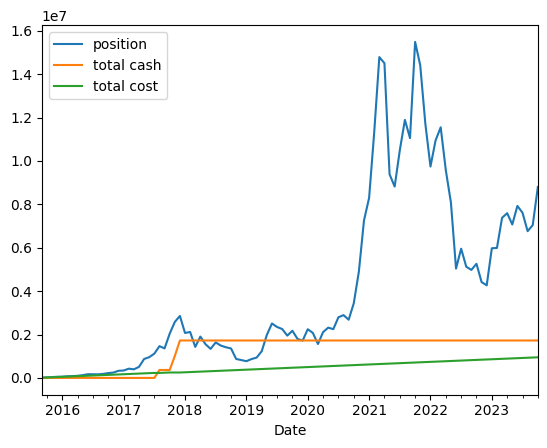

In [6]:
# position is holding position,initial position is 0, we did not buy any bitcoin at firt.
position = [0]
# cash position
cash = [0]
# cost position
cost = [0]

for pct_change, ind in zip(mpct_change, mindicator):

  # last position is position[-1],position[-1] * pct_change is ups and downs of holding positions
  newposition = position[-1] * pct_change

  # delta is reinvest funds every month
  delta = 0

  #################Simulate funds in and out#####################

  if ind < 3: # cheap

    delta = 10000

  else: # expensive
    # withdrawal
    delta = - 0.2 * newposition

  ###############################################################


  position.append(newposition + delta)

  if delta < 0:
    cash.append(-delta)
  else:
    cash.append(0)

  if delta > 0:
    cost.append(delta)
  else:
    cost.append(0)

position = pd.Series(position[1:], index=mclose.index)
cash = pd.Series(cash[1:], index=mclose.index)
cost = pd.Series(cost[1:], index=mclose.index)

# Diff:add legend
import matplotlib.pyplot as plt
position.plot(label='position')
cash.cumsum().plot(label='total cash')
cost.cumsum().plot(label='total cost')
plt.legend()